# HANDS-ON PRACTICE SESSION 3: PRACTICAL CONSIDERATIONS

SO Basics of Neural Networks 2023 school at the IAA-CSIC. Nov 2023.  
Eduardo Sánchez Karhunen  (fesanchez@us.es)  
University of Seville. Spain.  Dept. of CS and AI

### Introduction

In the last session, a CNN was designed to tackle the Galaxy10 classification problem. The obtained accuracy was approx. 71%.

In this third practice we are going to apply some improvements to our CNNs. Basically:
* Early Stopping
* Drop-out
* Data-Augmentation

The final goal of these techniques is to obtain an improvement in the network classification results, fighting against the overfitting.

### 1. Loading libraries

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# only execute this lines if the following error appears
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Exercise 0: Dataset preparation

As in the previous session, download the dataset to your local disk.

In [ ]:
# LINUX
!wget http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

# WINDOWS
# !curl "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5" --output Galaxy10.h5

--2023-11-14 01:52:02--  http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M)
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  50.0MB/s    in 4.4s    

2023-11-14 01:52:07 (45.7 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



Convert the downloaded h5 files into two numpy arrays containing images and labels.

In [ ]:
hf = h5py.File('Galaxy10.h5', 'r')
labels, images = hf.get('ans')[()], hf.get('images')[()]

Check the shape of the dataset.

In [ ]:
n_images, *shape, n_channels = images.shape
print(f"number of images: {n_images}")
print(f"shape of each image: {shape}")
print(f"number of channels: {n_channels}")

number of images: 21785
shape of each image: [69, 69]
number of channels: 3


### Exercise 1. Create train and test datasets

Divide the dataset into two new datasets for:
* training: 90%
* test: 10%  

Use the `train_test_split` command from scikit_learn. Do not worry for the validation dataset. We will create it in a posterior step.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

**Task:** Create the following arrays: `train_images`, `train_labels`, `test_images` and `test_labels`.

In [ ]:
# your code here

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), test_size=0.1, random_state=42)
train_images, train_labels, test_images, test_labels = images[train_idx], labels[train_idx], images[test_idx], labels[test_idx]

### Exercise 2. Initialize ImageGenerators

ImageGenerators are needed to apply data-augmentation. It can be taken advantage of them to rescale and split data into train and validation in the same step.

Remember:
* Scaling the pixel values is always needed. Use the param `rescale` to indicate de scaling value.
* As a network designer you must decide which augmentation techniques fit better to your concrete problem. Probably some of them are not useful and can produce confusion between classes. In this case you can safely use horizontal flip.

* We can also split validation data at this moment. Using `validation_split` argument to indicate the size. A typical split value is 0.2.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

**Task:** Create an ImageDataGenerator to rescale, split validation data and apply horizontal flip aaugmentations.

In [ ]:
# your code here

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.2)

### Exercise 3. Connect ImageGenerators with data arrays

Once created the generator, it must be applied to our data arrays. Depending of the data location, different methods can be applied:

* **flow_from_directory**: if data is stored in the typical folder structure (one folder for each class).
* **flow**: when data in stored in numpy arrays in memory. Our Galaxy10 dataset is enough small to load it into a numpy array in memory.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow and https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

**Task:** Create two generators `train_generator`and `validation_generator` connected with arrays `train_images` and `train_labels`.

Hint: in both cases, the input arguments are the same: train_images and train_labels. The third argument indicates if the desired gen is for training or for validation.


In [ ]:
# your code here

train_generator = datagen.flow(train_images, train_labels, subset='training')
validation_generator = datagen.flow(train_images, train_labels, subset='validation')

### Exercise 4. Building the CNN model

Remember to follow this same schema:

<br>

![picture](https://drive.google.com/uc?id=1k8aHjwHlRP3wgU-IAtpKbcvwqyvvyUwY)


The parameters of the different layers are:

A) Convolutional layer
* 12 kernels (3x3)
* Stride = 1. The kernel will be shifted pixel by pixel along the image.
* No-padding. In Tensorflow, this is indicated as padding = `valid`.

B) Pooling layer
* pool_size = 2x2
* stride = 2

C) Flatten layer  
D) Two dense layers with 500 and 100 neurons, respectively.

**Task:** create a `conv_1`, `pool_1`, `flatten_layer`, `dense_1`, `dense_2` and `output_layer` with the previous parameters.

In [ ]:
# your code here

conv_1 = tf.keras.layers.Conv2D(filters=12,               # number of filters (number of kernels)
                                kernel_size=(3, 3),       # kernel shape
                                strides=(1, 1),           # how shift kernel moving along the image
                                padding='valid',          # either to include padding or not
                                activation='relu',        # activation function
                                name='conv_1',
                                input_shape=(69, 69, 3))

pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool_1')
flatten_layer = tf.keras.layers.Flatten()
dense_1 = tf.keras.layers.Dense(units=500, activation='relu', name='dense_1')
dense_2 = tf.keras.layers.Dense(units=100, activation='relu', name='dense_2')
output_layer = tf.keras.layers.Dense(units=10, activation='softmax', name='output_layer')

### Exercise 5. Dropout layer

Dropout layers can be inserted almost in any position in the network. We will add three of them after the flatten and both dense layers.

More info: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

**Task:** Create three dropout layers `do_1`, `do_2` and `do_3` with drop_rate 0.35.

In [ ]:
# your code here

do_1 = tf.keras.layers.Dropout(0.35)
do_2 = tf.keras.layers.Dropout(0.35)
do_3 = tf.keras.layers.Dropout(0.35)

### Exercise 6. Join all layers in a CNN

The first step is to create a `sequential` structure to be filled with the previously created layers.

More info in: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

**Task:** Collect all the previous layers in a `model`.

In [ ]:
# your code here

# input shape: (69,69,3)
model = tf.keras.Sequential()

model.add(conv_1)
# output shape: (67,67,12)

model.add(pool_1)
# output shape: (33,33,12)

model.add(flatten_layer)
# output shape: 13068
model.add(tf.keras.layers.Dropout(0.35))

model.add(dense_1)
# output shape: 500
model.add(tf.keras.layers.Dropout(0.35))

model.add(dense_2)
# output shape: 100
model.add(tf.keras.layers.Dropout(0.35))

model.add(output_layer)
# output shape: 10


### Exercise 7. Model inspection

In the model summary we can check the three new dropout layers have been added. Of course, these layers have no parameters.

**Task:** show a summary of the network

In [ ]:
# your code here

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 67, 67, 12)        336       
                                                                 
 pool_1 (MaxPooling2D)       (None, 33, 33, 12)        0         
                                                                 
 flatten (Flatten)           (None, 13068)             0         
                                                                 
 dropout_3 (Dropout)         (None, 13068)             0         
                                                                 
 dense_1 (Dense)             (None, 500)               6534500   
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               5

### Exercise 8. Assign loss function and optimizer

**Task:** assign the classical parameters to the network

In [ ]:
# your code here

loss_function = tf.keras.losses.sparse_categorical_crossentropy
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    loss=loss_function,
    optimizer=optim,
    metrics=['accuracy'])

### Exercise 9. Create an early stopping callback

Remeber EarlyStopping has two parameters:
* patience
* restore_best_weights

**Task:** Create an early stopping callback `es_callback` with patience = 4. Restore best weights when training finishes.

In [ ]:
# your code here

es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

### Exercise 10. Network training

Remember:
* Use early stopping in training via the `callbacks` parameter. It expects a list, even if there is only one callback
* Validation_split is no more needed because this task has been performed by our generators.
* Use as training and validation data the two previously created generators
* Increase the number of epochs. e.g. 30 epochs.

More info: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

**Task:** Train the model with the selected number of epochs, callback and using the generators (save the training history)

In [ ]:
# your code here

history = model.fit(train_generator, validation_data=validation_generator, epochs=30,callbacks=[es_callback])

Epoch 1/30
491/491 [==============================] - 14s 7ms/step - loss: 1.4631 - accuracy: 0.3982 - val_loss: 1.2067 - val_accuracy: 0.4894
Epoch 2/30
491/491 [==============================] - 3s 6ms/step - loss: 1.1990 - accuracy: 0.5180 - val_loss: 1.0491 - val_accuracy: 0.5970
Epoch 3/30
491/491 [==============================] - 3s 6ms/step - loss: 1.0692 - accuracy: 0.5957 - val_loss: 0.9277 - val_accuracy: 0.6707
Epoch 4/30
491/491 [==============================] - 3s 6ms/step - loss: 0.9785 - accuracy: 0.6414 - val_loss: 0.8853 - val_accuracy: 0.6626
Epoch 5/30
491/491 [==============================] - 3s 6ms/step - loss: 0.9299 - accuracy: 0.6564 - val_loss: 0.8062 - val_accuracy: 0.6932
Epoch 6/30
491/491 [==============================] - 3s 6ms/step - loss: 0.8850 - accuracy: 0.6755 - val_loss: 0.8851 - val_accuracy: 0.6832
Epoch 7/30
491/491 [==============================] - 3s 6ms/step - loss: 0.8427 - accuracy: 0.6900 - val_loss: 0.7768 - val_accuracy: 0.7118
Epoch

### Exercise 11: Plot training history

It is a good practice to plot our training curves. Typically we compare the evolution of loss function (accuracy) vs epochs.

**Task:** Plot train and valid loss (and accuracy) evolution during training

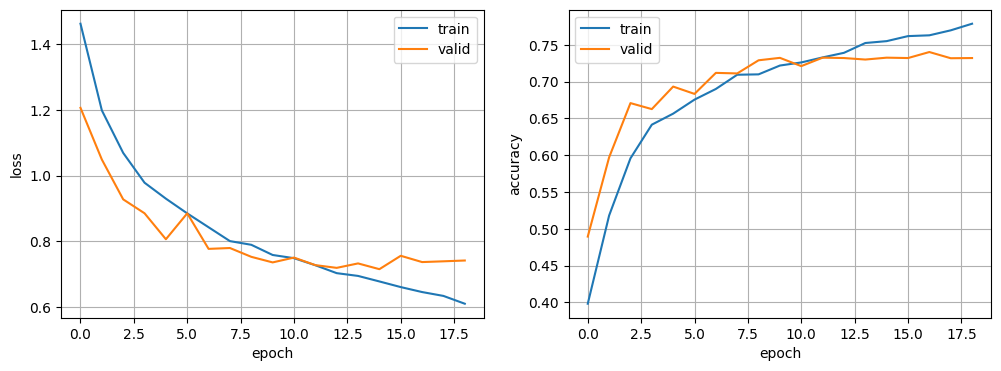

In [ ]:
# your code here

df_1 = pd.DataFrame({'loss_train': history.history['loss'],
                     'loss_valid': history.history['val_loss']
                    })

df_2 = pd.DataFrame({'accuracy': history.history['accuracy'],
                   'accuracy_valid': history.history['val_accuracy']
                   })

data = [df_1, df_2]
y_labels = ['loss', 'accuracy']

f, axs = plt.subplots(1, 2, sharex=True, figsize=(12,4))
for ax, y_label, df in zip(axs, y_labels, data):
    ax.plot(df, label=['train','valid'])
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel(y_label)
    ax.legend();

### Exercise 12. Evaluate model accuracy

To evaluate the model accuracy in the test dataset, first you must rescale `test_images`. You can do it in the traditional way, as in the previous practices or creating a generator simply for scaling.

**Task:** Once trained the model, obtain the accuracy of the model on the test dataset.

In [ ]:
# your code here

datagen_rescale = ImageDataGenerator(rescale=1./255)
test_datagen = datagen_rescale.flow(test_images, test_labels)

res = model.evaluate(test_datagen, verbose=0)
print(f"model accuracy: {np.round(res[1],2)}")

model accuracy: 0.72


### Exercise 13: Making predictions with the model

Given an input image, the `predict` method returns the output of the last layer. This output is interpreted as the probability of the image to correspond to each of the classes.

**Task:** Inject to the model 10 images from the test dataset to obtain their probabilities.

In [ ]:
# your code here

X_new = test_images[:10]/255.0
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 97ms/step


array([[0.16, 0.58, 0.14, 0.  , 0.  , 0.  , 0.  , 0.09, 0.03, 0.01],
       [0.04, 0.95, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.3 , 0.62, 0.06, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ],
       [0.  , 0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.91, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.18, 0.  , 0.79, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01],
       [0.  , 0.09, 0.91, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.95, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.09, 0.9 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.16, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.06, 0.  ]],
      dtype=float32)

**Task:** Using `np.argmax` and the probabilities, decide which is the class of each image

In [ ]:
# your code here

y_predicted = np.argmax(y_proba.round(2), axis=1)
y_predicted

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 1])

**Task:** Finally, compare the predicted classes with the real ones. There should be approx. 75% of correct predictions.

In [ ]:
# your code here

test_labels[:10]

array([0, 1, 1, 1, 1, 2, 2, 2, 2, 7], dtype=uint8)